In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, scan, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-05-26 14:41:44,639][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-05-26 14:41:44,694][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.0'

1. Get latest dataset from Natasha from database
2. load 2p movie to array. 
3. load top-video to array
4. find the Start and end frames of the movie with respect to the tracking gate 

In [2]:
import bisect
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import concurrent.futures
import cv2

def get_closest_timestamps(series, target_timestamp):
    # List to store the indices
    indices = []

    # For each timestamp in series1, find the closest timestamp in series2 and get its index
    for t1 in series:
        closest_index = closest_timestamp(target_timestamp, t1)
        indices.append(closest_index)
    return indices

# Function to find closest timestamp
def closest_timestamp(series, target_timestamp):
    index = bisect.bisect_left(series, target_timestamp)
    if index == 0:
        return 0
    if index == len(series):
        return len(series)-1
    before = series[index - 1]
    after = series[index]
    if after - target_timestamp < target_timestamp - before:
       return index
    else:
       return index-1


def resize_movie(movie, new_height, new_width):
    # Get the number of frames and color channels
    num_frames, _, _, num_channels = movie.shape
    
    # Initialize an empty array for the scaled movie
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)
    
    # Iterate through each frame
    for i in tqdm(range(num_frames), desc="Resizing frames"):
        # Resize the frame and store it in the new array
        scaled_movie[i] =  cv2.resize(movie[i], (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    # Return the scaled movie
    return scaled_movie


def resize_frame(frame, new_height, new_width):
    return cv2.resize(frame, (new_width, new_height), interpolation = cv2.INTER_AREA)

def resize_movie_mt(movie, new_height, new_width):
    num_frames, _, _, num_channels = movie.shape
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, resized_frame in tqdm(enumerate(executor.map(resize_frame, movie, [new_height]*num_frames, [new_width]*num_frames)), total=num_frames, desc="Resizing frames"):
            scaled_movie[i] = resized_frame

    return scaled_movie


import numpy as np
from skimage.transform import resize
import concurrent.futures



In [3]:
# defining queries - example for latest recording sessino of specific user

# select user
user = "NK"
userquery = (session.SessionUser * subject.User() & f'initials = "{user}"')


# get the latest session
usesession = session.Session.fetch(order_by='session_datetime DESC', as_dict=True)[0]["session_id"]
sessionquery = session.Session &  f'session_id = "{usesession}"'

scansi = (scan.Scan & sessionquery).fetch('scan_id')[0]

scanquery = scan.Scan & f'scan_id = "{scansi}"'


In [25]:
# defining queries - example for directly giving scan number


scansi = "scan9FI3KWP3"

scanquery = scan.Scan & f'scan_id = "{scansi}"'


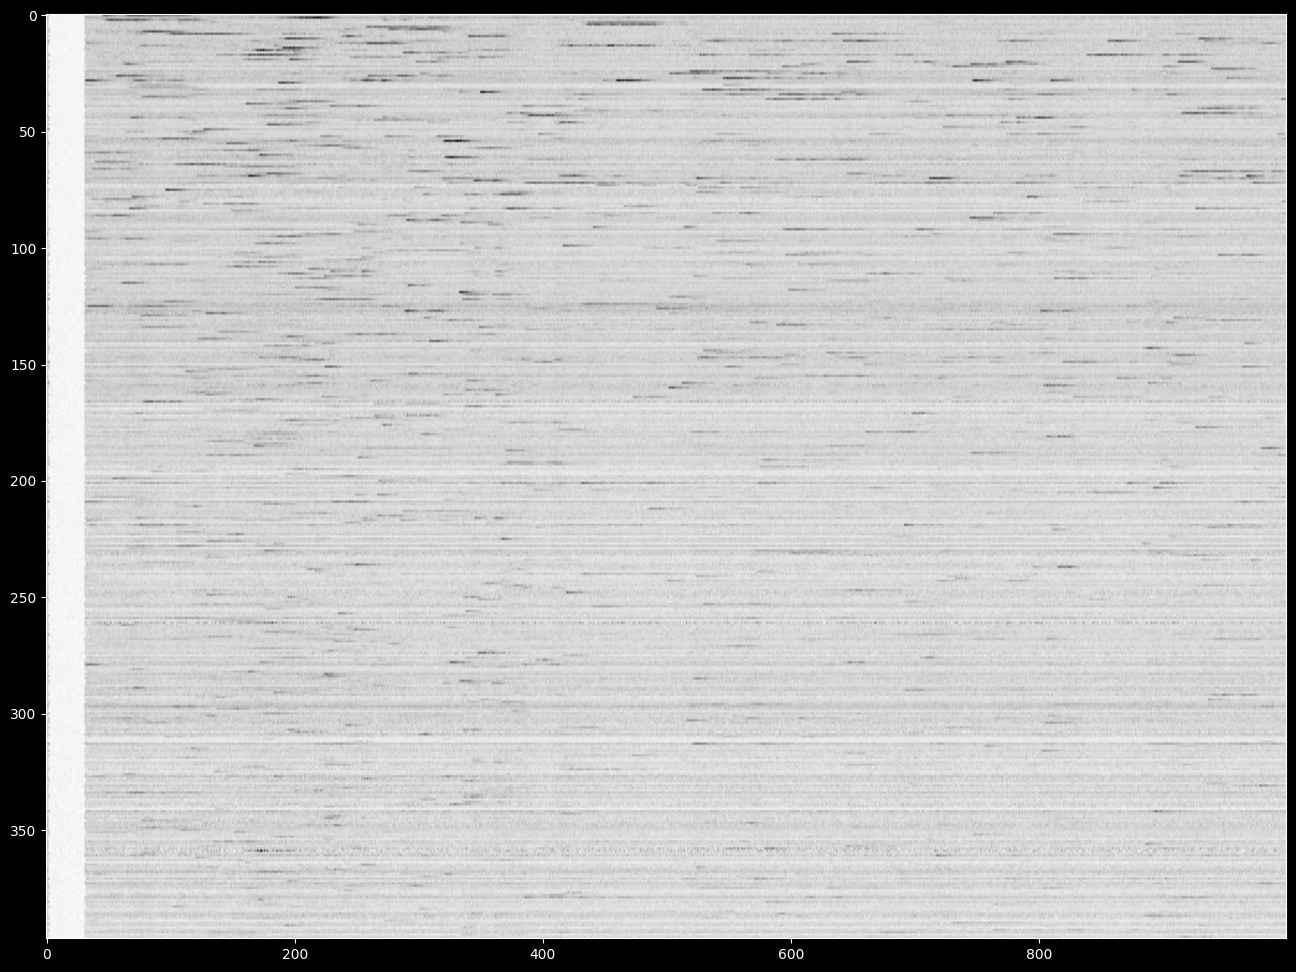

In [26]:
fluos = np.vstack((scanquery * imaging.Fluorescence.Trace).fetch("fluorescence"))
plt.figure(figsize=(16,12))
plt.imshow(fluos, aspect='auto', cmap='gray_r')

In [27]:
from rastermap import Rastermap
from scipy import stats 
from scipy.ndimage import gaussian_filter1d

ops = {'n_components': 1, 'n_X': 100, 'alpha': 1., 'K': 1.,
            'nPC': 200, 'constraints': 2, 'annealing': True, 'init': 'pca',
            'start_time': 0, 'end_time': -1}

S = np.vstack(fluos)# deconvolved
# S = nXp.vstack(fluorescence_traces)
# we run rastermap the same way that the other scikit-learn embedding algorithms work
# model = Rastermap(n_components=1, n_X=100, verbose = True).fit(S) 
model = Rastermap(n_components=ops['n_components'], n_X=ops['n_X'], nPC=ops['nPC'],
                          init=ops['init'], alpha=ops['alpha'], K=ops['K'], constraints=ops['constraints'],
                          annealing=ops['annealing'])
model.fit(S)
# def running_average(X, nbin = 10):
#     Y = np.cumsum(X, axis=0)
#     Y = Y[nbin:, :] - Y[:-nbin, :]
#     return Y
# the manifold embedding is in model.embedding
isort = np.argsort(model.embedding[:,0])

# sort by embedding and smooth over neurons
# Sfilt = running_average(S[isort], 0)
Sfilt = gaussian_filter1d(S[isort], np.minimum(8,np.maximum(1,int(S.shape[0]*0.001))),axis=0)
# Sfilt = np.vstack(fluorescence_traces)
Sfilt = stats.zscore(Sfilt, axis=1)



nmin 200
0.0007586479187011719
0.11255574226379395
0.11371660232543945
0.11501002311706543
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.3200      2
0.03s    10        0.4416      4
0.06s    20        0.5002      8
0.09s    30        0.5494      18
0.12s    40        0.6035      28
0.15s    50        0.6284      38
0.18s    60        0.6519      48
0.22s    70        0.6755      58
0.26s    80        0.6907      68
0.29s    90        0.7074      78
0.32s    100        0.7254      88
0.35s    110        0.7430      98
0.39s    120        0.7430      98
0.41s   final      0.7430
0.42s upsampled    0.7430


Text(0, 0.5, 'sorted neurons')

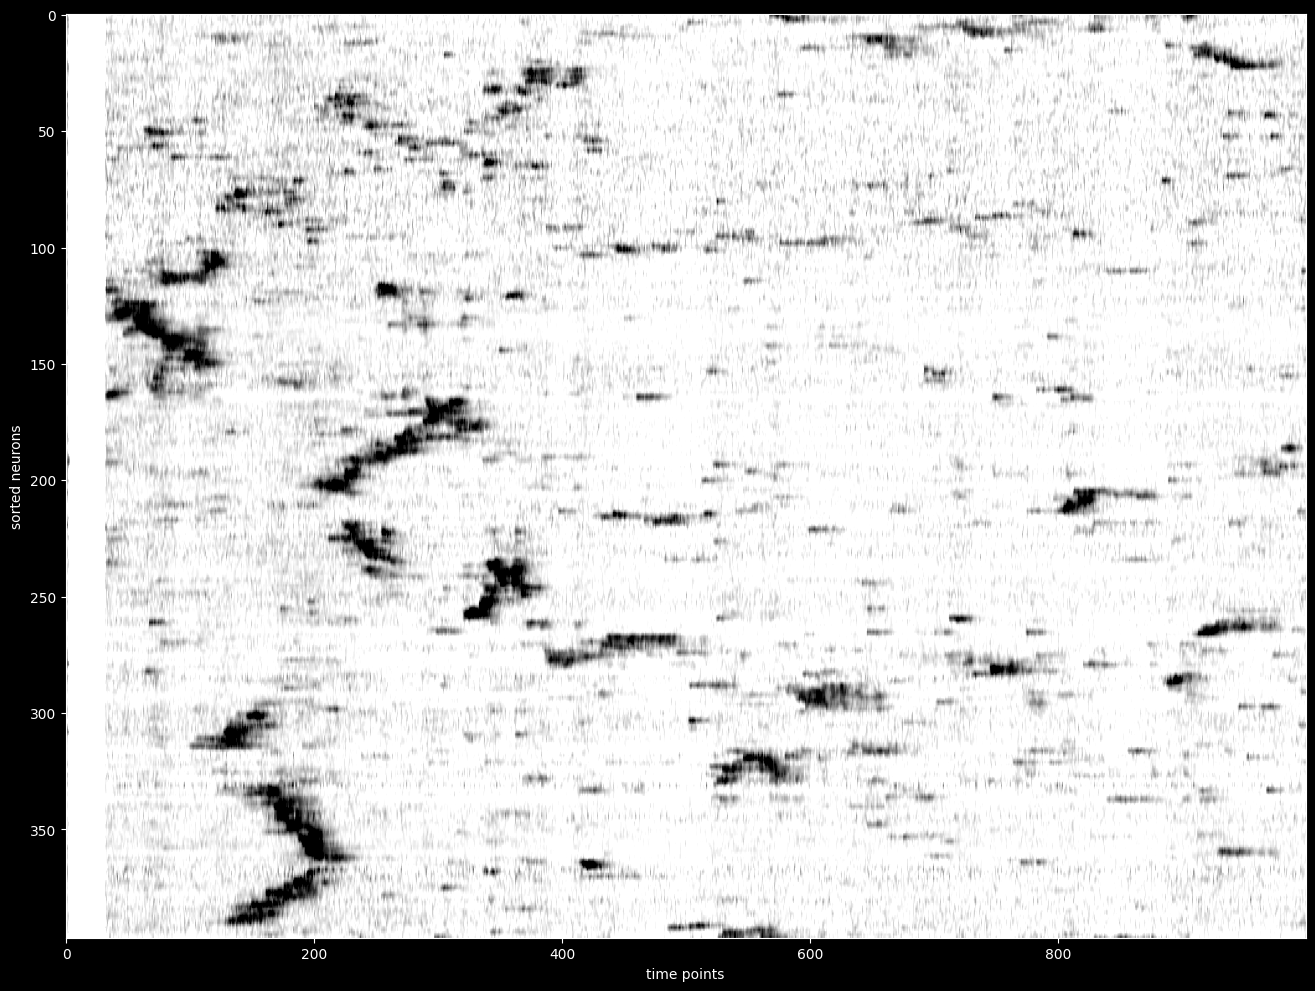

In [28]:
plt.figure(figsize=(16,12))
plt.imshow(Sfilt, vmin = -0.1, vmax=4, aspect='auto', cmap='gray_r')
plt.xlabel('time points')
plt.ylabel('sorted neurons')
# plt.show()

### MOVIES

In [29]:
from pathlib import Path
import skvideo.io

# get the main data directory of the specified scanID 

dir = (scan.ScanPath & scanquery).fetch('path')

# get the top cam movie of that session
directory = Path(dir[0])
pattern = '*top_video*.mp4'
files = list(directory.glob(pattern))

#load to array
videodata = skvideo.io.vread(str(files[0]))
videodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in videodata], dtype=np.uint8)

In [30]:
# get the registered moving average (blinking) movie data of the specified scanID
directory = Path(dir[0] + "/suite2p/plane0/reg_tif")
pattern = '*20_frame*.mp4'
files = list(directory.glob(pattern))
blinkvideodata = skvideo.io.vread(str(files[0]))
blinkvideodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in blinkvideodata], dtype=np.uint8)

#dimensionts of the original movie (frames, x,y,rgb)
print(videodata.shape)
print(blinkvideodata.shape)

(37200, 1000, 1000, 3)
(1000, 512, 512, 3)


In [31]:
# display camaravideo with slider
sh.display_volume_z(videodata,1)

interactive(children=(IntSlider(value=0, description='z', max=37199), Output()), _dom_classes=('widget-interac…

In [32]:
# display 2pstackvideo with slider
sh.display_volume_z(blinkvideodata,1)

interactive(children=(IntSlider(value=0, description='z', max=999), Output()), _dom_classes=('widget-interact'…

#### Synchronization!

In [33]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scanquery).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scanquery ).fetch('event_start_time')

twoptimestamps =  twoptimestamps[:np.shape(blinkvideodata)[0]] # truncating 2p timestamps to number of 2p videoframes

#  Zero camera timestamps on first 2p timestamp. (not necessary)
# cameratimestamps = cameratimestamps - twoptimestamps[0]
# twoptimestamps = twoptimestamps - twoptimestamps[0]

In [34]:
event.Event() & scanquery  &  "event_type='aux_cam'"

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.0,0.005
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.01665,0.02165
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.03335,0.03835
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.05,0.055
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.06665,0.07165
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.08335,0.08835
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.1,0.105
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.11665,0.12165
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.13335,0.13835
sess9FI3KWP3,scan9FI3KWP3,aux_cam,0.15,0.155


In [35]:
# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


(1000,)


In [36]:

# now use this camara frame indices to reslice the video (which now is aligned to the 2p frames on a frame-by-frame level)
resliced_cam_video = videodata[aligned_cameraframes]

In [37]:
# display synchronized movie
sh.display_volume_z(resliced_cam_video,1)

interactive(children=(IntSlider(value=0, description='z', max=999), Output()), _dom_classes=('widget-interact'…

In [38]:
# rescale camera movie to fit size of 2p movie (can take a lot of time and memory)
rescaled_cam_movie = resize_movie(resliced_cam_video, np.shape(blinkvideodata)[1],np.shape(blinkvideodata)[2])

Resizing frames: 100%|██████████| 1000/1000 [00:02<00:00, 399.60it/s]


In [39]:
np.shape(rescaled_cam_movie)

(1000, 512, 512, 3)

In [40]:
# concatenate and display movies
concatmovie = np.concatenate((blinkvideodata,rescaled_cam_movie), axis = 2)
sh.display_volume_z(concatmovie,1)

interactive(children=(IntSlider(value=0, description='z', max=999), Output()), _dom_classes=('widget-interact'…

In [41]:
#save as new movie (without rescaling)


filename = str(directory) + '/aligned_stack_cam_movie.mp4'
fps = (scan.ScanInfo & scanquery).fetch('fps')
# p1 = 0
# p2 = 100
# trash = sh.make_stack_movie(concatmovie, filename, fps[0], p1, p2)

codecset = 'libx264'
import imageio
import imageio.plugins.ffmpeg as ffmpeg

# Create an imageio VideoWriter object to write the video
writer = imageio.get_writer(filename, fps=fps[0], codec=codecset, output_params=['-crf', '19'])

# # Calculate the 1st and 99th percentile
# p1, p99 = np.percentile(running_z_projection[:500,:,:], (p1set, p2set))

# # rescale to 8 bit
# rescaled_image_8bit = rescale_image_multithreaded(running_z_projection, p1, p99)

for page in concatmovie:
    writer.append_data(page)

# Close the video writer
writer.close()


In [42]:
# speed up, add timestamps etc - all with fast ffmpeg operations

import os

spedby = 5
setpts_value = 1/spedby # change this to your desired value
newfps = fps[0]*spedby

input_filename = filename
# 2. Add timestamps

output_filename = str(directory) + '/' + scansi + '_top_video_concatenated' + 'withtimestamps.mp4'
command = f"""ffmpeg -y -i {input_filename} -vf "drawtext=fontfile=/Library/Fonts/Arial.ttf:timecode='00\\\\:00\\\\:00\\\\:00':rate={fps[0]}:text='':fontsize=20:fontcolor=white:x=530:y=20:box=1:boxcolor=0x00000000@1" -f mp4 {output_filename}"""

os.system(command)


input_filename = output_filename  # 'sped_up_video.mp4'
output_filename = str(directory) + '/' +  scansi + '_top_video_concatenated_spedup_' + str(spedby) + 'fold_withtimestamps.mp4'

command = f'ffmpeg -y -i {input_filename} -vf "setpts={setpts_value}*PTS" -r {newfps}  {output_filename}'



os.system(command)


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

0

###  Synchronization of Flash stimulus with 2p data

In [23]:
event.EventType()

event_type,event_type_description
arena_LED,
aux_bpod_cam,
aux_bpod_reward,
aux_bpod_tone,
aux_bpod_visual,
aux_cam,
HARP_gate,
main_track_gate,
mini2p_frames,
mini2p_lines,


In [24]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_start_time')

# Then return FlashStim start timestamps within the recording gate only 
flashtimestamps = (event.Event()  &  "event_type='arena_LED'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scanquery).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scanquery ).fetch('event_start_time')



In [ ]:
print(flashtimestamps)

In [ ]:
# now get the 2p frame indices that correspond most closely to these timestamps
flash_aligned_2pframes = get_closest_timestamps(flashtimestamps, twoptimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(flash_aligned_2pframes))

In [ ]:
print(flash_aligned_2pframes)

### IMU

In [ ]:
event.BehaviorRecording.File()

In [ ]:
 dj.Diagram(event) +dj.Diagram(trial) + 100